In [110]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# 读取数据
rfr_importance = pd.read_csv("dataset_train.csv")

# 特征和标签
X_cols = [
    # "Height (m MSL)",
    "B1",
    "B2",
    "B3",
    "B4",
    "B5",
    "B6",
    "B7",
    "B8",
    "B8A",
    "B9",
    "B11",
    "B12",
]
Y_col = "real_height"

# 取出特征和标签
X = rfr_importance[X_cols].values
y = rfr_importance[Y_col].values

## 特征重要性排名

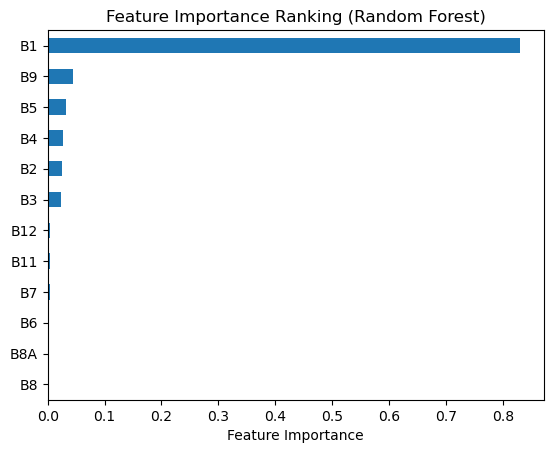

In [111]:
model = RandomForestRegressor()
model.fit(X, y)
importances = model.feature_importances_
feature_names = X_cols

# 绘制特征重要性排名
rfr_importance = pd.Series(importances, index=feature_names).sort_values(ascending=True)
rfr_importance.plot(
    kind="barh",
    title="Feature Importance Ranking (Random Forest)",
    xlabel="Feature Importance",
)
plt.show()

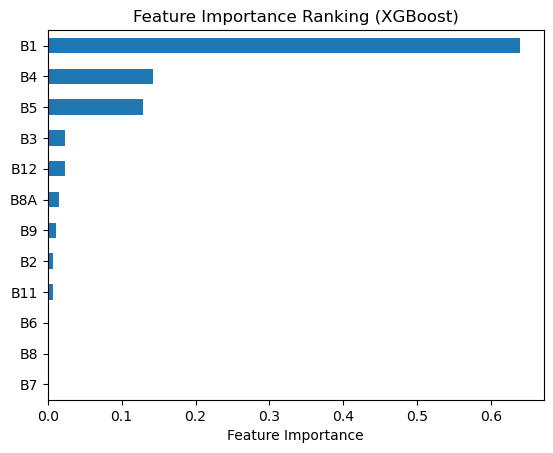

In [ ]:
import xgboost as xgb

model = xgb.XGBRegressor(n_estimators=100, random_state=42)
model.fit(X, y)
xgb_importance = pd.Series(model.feature_importances_, index=X_cols).sort_values(ascending=True)
xgb_importance.plot(
    kind="barh",
    title="Feature Importance Ranking (XGBoost)",
    xlabel="Feature Importance",
)
plt.show()

<Axes: title={'center': 'Feature Importance Ranking (Mutual Information)'}, xlabel='Mutual Information Score'>

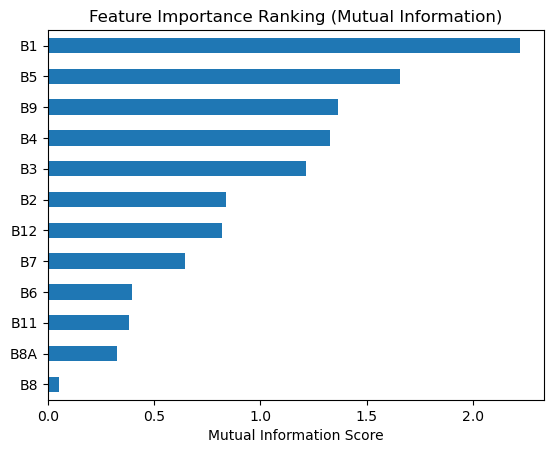

In [113]:
from sklearn.feature_selection import mutual_info_regression
from scipy.spatial.distance import pdist, squareform

# 互信息
mi_scores = mutual_info_regression(X, y, random_state=42)
mi_importance = pd.Series(mi_scores, index=X_cols).sort_values(ascending=True)
mi_importance.plot(
    kind="barh",
    title="Feature Importance Ranking (Mutual Information)",
    xlabel="Mutual Information Score",
)

Selected Features (Lasso): ['B1', 'B3']
Zero Coefficient Features (Lasso): ['B2', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


<Axes: title={'center': 'Feature Importance Ranking (Lasso)'}, xlabel='Coefficient Value', ylabel='Feature'>

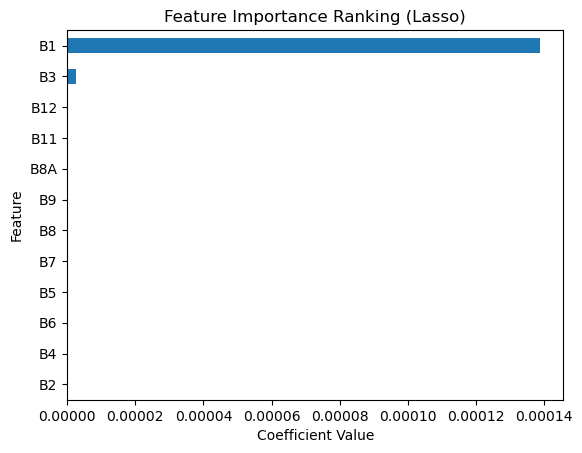

In [126]:
from sklearn.linear_model import LassoCV
import numpy as np

lasso = LassoCV(cv=5)
lasso.fit(X, y)
X_cols_array = np.array(X_cols)
non_zero_features = X_cols_array[lasso.coef_ != 0]
zero_features = X_cols_array[lasso.coef_ == 0]
print("Selected Features (Lasso):", non_zero_features.tolist())
print("Zero Coefficient Features (Lasso):", zero_features.tolist())

lasso_feature_coefficients = pd.Series(lasso.coef_, index=X_cols).sort_values(ascending=True)
lasso_feature_coefficients.plot(
    kind="barh",
    title="Feature Importance Ranking (Lasso)",
    xlabel="Coefficient Value",
    ylabel="Feature",
)
# plt.bar(range(len(X_cols)), lasso.coef_)
# plt.xticks(range(len(X_cols)), X_cols)

Feature Variances: [ 2812.09979951  9628.6856761  18350.6856761   2782.27132992
   660.34439742    53.42971709   102.99175763   111.94742704
    59.11205168    66.40899978    19.95010025    18.93250167]
High Variance Features: ['B1', 'B2', 'B3']
Low Variance Features: ['B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B9', 'B11', 'B12']


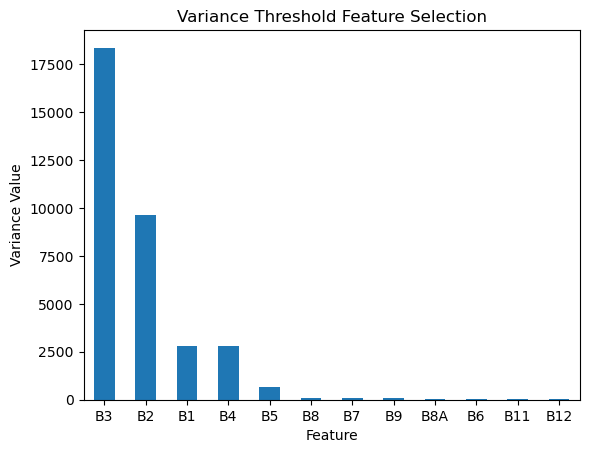

In [127]:
from sklearn.feature_selection import VarianceThreshold

# 计算所有特征的方差
variances = np.var(X, axis=0)
print("Feature Variances:", variances)
# 设置阈值为方差的75%分位数
threshold = np.quantile(variances, 0.75)

selector = VarianceThreshold(threshold=threshold)
X_high_var = selector.fit_transform(X)
# 将X_cols转换为NumPy数组
X_cols_array = np.array(X_cols)

# 使用布尔索引选择高方差特征
high_var_features = X_cols_array[selector.get_support()]
low_var_features = X_cols_array[~selector.get_support()]
print("High Variance Features:", high_var_features.tolist())
print("Low Variance Features:", low_var_features.tolist())

vtfs = pd.Series(variances, index=X_cols).sort_values(ascending=False)
vtfs.plot(
    kind="bar",
    title="Variance Threshold Feature Selection",
    xlabel="Feature",
    ylabel="Variance Value",
    rot=0
)
plt.show()

<Axes: title={'center': 'Combined Feature Importance (MI, RF, XGB)'}, xlabel='Normalized Importance Score'>

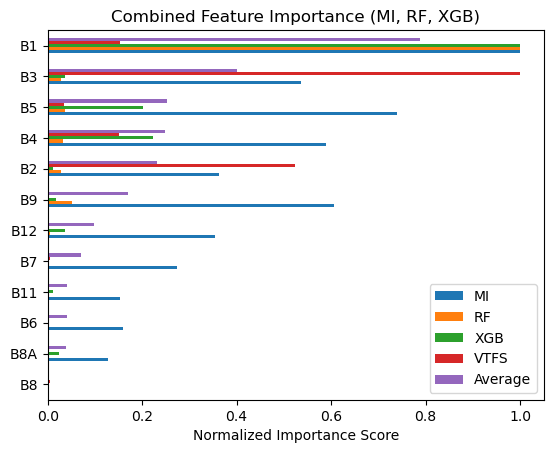

In [128]:
from sklearn.preprocessing import MinMaxScaler

# 合并所有重要性得分
importance_df = pd.DataFrame({
    'MI': mi_importance,
    'RF': rfr_importance,
    'XGB': xgb_importance,
    'VTFS': vtfs
})

# 标准化得分
scaler = MinMaxScaler()
importance_scaled = pd.DataFrame(
    scaler.fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# 计算平均重要性
importance_scaled['Average'] = importance_scaled.mean(axis=1)

# 按重要性排序
sorted_features = importance_scaled.sort_values('Average', ascending=True)
sorted_features.plot(
    kind="barh",
    title="Combined Feature Importance (MI, RF, XGB)",
    xlabel="Normalized Importance Score",
)